# Audio Classifier

In [138]:
from datasets import load_dataset
import torch

def pick_device() -> torch.device:
    if torch.backends.mps.is_available():
        print("Using mps backend")
        return torch.device("mps")
    if torch.cuda.is_available():
        print("Using cuda backend")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        return torch.device("cuda")
    print('No GPU available, using the CPU.')
    return torch.device("cpu")

def device_memory_allocated(device) ->float:
    if device.type == 'cuda':
        return torch.cuda.memory_summary(device=device, abbreviated=True)
    if device.type == 'mps':
        import torch.mps
        return torch.mps.current_allocated_memory()
    return 0

device = torch.device("cpu") # pick_device()

# Dataset

In [139]:
from pathlib import Path
from datasets import load_dataset, ReadInstruction

DATASET_NAME = "urbansound8k"
DATASET_PATH = Path("data/urbansound8k/")

# Prep datasets for 10-fold validation
# The recommended approach for this dataset. Temporarily use the 90/10 split below for
# testing out the model.
#
# trains = load_dataset("audiofolder", split=[
#     ReadInstruction('train', to=k, unit='%') + ReadInstruction('train', from_=k+10, unit='%')
#     for k in range(0, 100, 10)
# ], data_dir=str(DATASET_PATH), name=DATASET_NAME)
# tests = load_dataset("audiofolder", split=[
#     ReadInstruction('train', from_=k, to=k+10, unit='%')
#     for k in range(0, 100, 10)
# ], data_dir=str(DATASET_PATH), name=DATASET_NAME)

trains = [load_dataset("audiofolder", split="train[:90%]", data_dir=str(DATASET_PATH), name=DATASET_NAME)]
tests = [load_dataset("audiofolder", split="train[90%:]", data_dir=str(DATASET_PATH), name=DATASET_NAME)]


Resolving data files:   0%|          | 0/8736 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8736 [00:00<?, ?it/s]

In [140]:
from IPython.display import Audio

train0 = trains[0]

first_item = train0[0]
audio_filename = first_item['audio']['path']
audio_samples = first_item['audio']['array']
sr = first_item['audio']['sampling_rate']

print(f"Filename: {audio_filename}")
print(f"Sample rate: {sr}")
label = first_item['class']
print(f"Label: {label}")
print(f"Audio Fields: {first_item['audio'].keys()}")
print(f"Len: {len(audio_samples)}")
Audio(audio_filename, rate=sr)

Filename: /Users/allen/Development/ml-papers/audio-features/data/urbansound8k/audio/fold1/101415-3-0-2.wav
Sample rate: 48000
Label: dog_bark
Audio Fields: dict_keys(['path', 'array', 'sampling_rate'])
Len: 192000


# Pre-process Dataset

In [141]:
import torch
from io import BytesIO
import torchaudio
from torchaudio import transforms as T
from torch.nn import functional as F
from typing import Any

N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050  # 1 second samples

mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT, 
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)


def transform_item(item: dict) -> dict:
    """Compute the mel spectrogram and truncate or pad the sample."""
    arr = item['audio']['array']  # numpy array
    audio = torch.tensor(arr, dtype=torch.float32)
    sr = item['audio']['sampling_rate']
    if sr != SAMPLE_RATE:
        audio = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(audio)
    # Trim if too long
    audio_len = len(audio)
    if audio_len > NUM_SAMPLES:
        audio = audio[:NUM_SAMPLES]
    # Pad if too short
    if audio_len < NUM_SAMPLES:
        missing_samples = NUM_SAMPLES - audio_len
        audio = F.pad(audio, (0, missing_samples))
    item['tensor'] = mel_spectrogram(audio)
    return item

In [142]:
from datasets import Dataset, DatasetDict

CACHE_FILE_PREFIX = f"data/preprocess"

def preprocess_dataset(ds: Dataset, split: str) -> DatasetDict:
    return ds.map(
        transform_item,
        remove_columns=["audio", "fsID", "start", "end", "fold", "salience"],
        cache_file_name=f"{CACHE_FILE_PREFIX}-{split}.cache",
        desc=f"urbansound8k preprocessing ({split})",
        writer_batch_size=64,
    ).with_format("torch")

# Preprocess all datasets for 10-fold validation. This takes awhile but doing this
# up front significantly reduces the amount of data read later. (e.g. result is ~80MB per fold)
trains_ds: list[DatasetDict] = [preprocess_dataset(ds, f"trains-{i}") for i, ds in enumerate(trains)]
tests_ds: list[DatasetDict] = [preprocess_dataset(ds, f"test-{i}") for i, ds in enumerate(tests)]


urbansound8k preprocessing (trains-0):   0%|          | 0/7859 [00:00<?, ? examples/s]

urbansound8k preprocessing (test-0):   0%|          | 0/873 [00:00<?, ? examples/s]

In [144]:
# Samples are uniform size: (22k samples/sec) * (1 sec / 512 hops) = 44 frames
print([ trains_ds[0][i]['tensor'].shape for i in range(0, 5) ])
print([ tests_ds[0][i]['tensor'].shape for i in range(0, 5) ])

[torch.Size([64, 44]), torch.Size([64, 44]), torch.Size([64, 44]), torch.Size([64, 44]), torch.Size([64, 44])]
[torch.Size([64, 44]), torch.Size([64, 44]), torch.Size([64, 44]), torch.Size([64, 44]), torch.Size([64, 44])]


In [145]:
idx_to_class = { item['classID'].item(): item['class'] for item in trains_ds[0] }
class_to_idx = { v: k for k, v in idx_to_class.items() }
print(idx_to_class)

{3: 'dog_bark', 6: 'gun_shot', 7: 'jackhammer', 5: 'engine_idling', 2: 'children_playing', 8: 'siren', 9: 'street_music', 0: 'air_conditioner', 4: 'drilling', 1: 'car_horn'}


# CNN for Classification

In [155]:
from torch import nn
from torchsummary import summary

CONV_KERNEL_SIZE = 3
CONV_PADDING = 2
CONV_POOL_KERNEL_SIZE = 2


class CNN(nn.Module):
    """A CNN for audio classification."""

    def __init__(self, conv_channel_sizes: list[int], linear_size: int, num_classes: int) -> None:
        """Initialize CNN."""
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_channel_sizes[0],
                out_channels=conv_channel_sizes[1],
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=CONV_POOL_KERNEL_SIZE),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_channel_sizes[1],
                out_channels=conv_channel_sizes[2],
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=CONV_POOL_KERNEL_SIZE),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_channel_sizes[2],
                out_channels=conv_channel_sizes[3],
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=CONV_POOL_KERNEL_SIZE),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_channel_sizes[3],
                out_channels=conv_channel_sizes[4],
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=CONV_POOL_KERNEL_SIZE),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(linear_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        #self.layers = [self.conv, self.flatten, self.linear, self.softmax]

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        self.x_data = data
        self.x_conv1 = self.conv1(data)
        self.x_conv2 = self.conv2(self.x_conv1)
        self.x_conv3 = self.conv3(self.x_conv2)
        self.x_conv4 = self.conv4(self.x_conv3)
        self.x_flat = self.flatten(self.x_conv4)
        self.x_linear = self.linear(self.x_flat)
        # Disable softmax since it doesn't work with cross entropy loss
        #self.x_softmax = self.softmax(self.x_linear)
        return self.x_linear
    
conv_sizes = [1, 16, 32, 64, 128]
linear_size = conv_sizes[-1] * 5 * 4  # 5 * 4 is the size after conv2d and maxpool2d

model = CNN([1, 16, 32, 64, 128],  linear_size, len(class_to_idx))
summary(model, (1, 64, 44))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                   

In [156]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

g = torch.Generator(device=device).manual_seed(31337)
g_cpu = torch.Generator().manual_seed(31337)

MINI_BATCH_SZ = 128


def prepare_tensors(ds: Dataset) -> TensorDataset:
    """Prepare tensors for training and eval."""
    X = torch.stack([item['tensor'].unsqueeze(0) for item in ds]).type(torch.float32).to(device)
    Y = torch.stack([item['classID'] for item in ds]).to(device)
    return TensorDataset(X, Y)


def prepare_data_loader(
        train_ds: DatasetDict,
        test_ds: DatasetDict,
        batch_size: int
) -> tuple[DataLoader, DataLoader]:
    """Preparep dataset loaders"""
    tr_data = prepare_tensors(train_ds)
    tr_loader = DataLoader(
        tr_data,
        sampler=RandomSampler(tr_data, generator=g_cpu),
        batch_size=batch_size,
    )

    val_data = prepare_tensors(test_ds)
    val_loader = DataLoader(
        val_data,
        sampler=SequentialSampler(val_data),
        batch_size=batch_size,
    )
    return tr_loader, val_loader

data_loaders: list[tuple[DataLoader, DataLoader]] = []
for i in tqdm(range(0, len(trains_ds))):
    train_fold, test_fold = prepare_data_loader(trains_ds[i], tests_ds[i], MINI_BATCH_SZ)
    data_loaders.append([ train_fold, test_fold ])

100%|██████████| 1/1 [00:08<00:00,  8.00s/it]


# Training

In [157]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
from torch.optim import Optimizer
import numpy as np
import math
import time

MINI_BATCH_SZ = 128


def forward_step(model: nn.Module, batch: tuple[torch.Tensor, torch.Tensor], num_classes: int) -> tuple[torch.Tensor, float]:
    Xb, Yb = batch
    logits = model.forward(Xb)
    Yb_float = F.one_hot(Yb.long(), num_classes=num_classes).float()
    loss = F.cross_entropy(logits, Yb_float)
    
    with torch.no_grad():
        logits_classes = torch.argmax(logits, dim=1)
        accuracy = (logits_classes == Yb).sum().cpu()
    return loss, accuracy


def train(
    model: nn.Module,
    opt: Optimizer,
    tr_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    num_classes: int
) -> None:

    model.to(device)
    for epoch in range(num_epochs):
        model.train()

        lossi = []
        accuracyi = []
        t0_epoch = time.time()

        pbar = tqdm(enumerate(tr_loader))
        pbar.reset(total=len(tr_loader.dataset))

        with torch.enable_grad():
            for step, batch in pbar:
                loss, accuracy = forward_step(model, batch, num_classes)
                
                model.zero_grad()
                loss.backward()
                lossi.append(loss.item())
                accuracyi.append(accuracy)
                opt.step()

                pbar.update(MINI_BATCH_SZ)
                if step % 10 == 0:
                    pbar.set_description(f"Epoch {epoch} (tr) | Loss: {loss.item():0.3f} | Accuracy: {accuracy:0.2f}")

        pbar.close()
    
        avg_train_loss = np.mean(lossi)
        iters = len(lossi) * MINI_BATCH_SZ
        time_elapsed = time.time() - t0_epoch

        lossi = []
        accuracyi = []
        t0_epoch = time.time()
        model.eval()
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                loss, accuracy = forward_step(model, batch, num_classes)
                lossi.append(loss.item())
                accuracyi.append(accuracy)

            avg_eval_loss = np.mean(lossi)
            avg_eval_accuracy = np.mean(accuracyi)

        eval_time_elapsed = time.time() - t0_epoch

        print(f"Epoch {epoch} (val) | {iters/time_elapsed:3.2f}i/s | {avg_train_loss:0.3f} | {avg_eval_loss:0.3f} | {avg_eval_accuracy:0.2f} | {time_elapsed:^7.2f} / {eval_time_elapsed:^7.2f}")

       

In [158]:
lr = 0.01
num_epochs = 20
opt = torch.optim.Adam(model.parameters(), lr=lr)
#opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Use one of the 10 folds for training and validation for initial testing.
dl_train, dl_val = data_loaders[0]
print(device_memory_allocated(device))
train(model, opt, dl_train, dl_val, num_epochs, len(class_to_idx))

0


Epoch 0 (tr) | Loss: 2.070 | Accuracy: 23.00:   1%|          | 62/7859 [00:10<21:26,  6.06it/s]   


Epoch 0 (val) | 775.34i/s | 10.524 | 2.459 | 26.57 |  10.24  /  0.32  


Epoch 1 (tr) | Loss: 1.780 | Accuracy: 51.00:   1%|          | 62/7859 [00:09<20:50,  6.24it/s]   


Epoch 1 (val) | 798.16i/s | 1.846 | 2.100 | 37.86 |  9.94   /  0.30  


Epoch 2 (tr) | Loss: 1.557 | Accuracy: 47.00:   1%|          | 62/7859 [00:10<21:15,  6.11it/s]   


Epoch 2 (val) | 782.10i/s | 1.636 | 2.086 | 53.14 |  10.15  /  0.31  


Epoch 3 (tr) | Loss: 1.442 | Accuracy: 58.00:   1%|          | 62/7859 [00:10<21:10,  6.14it/s]   


Epoch 3 (val) | 785.57i/s | 1.531 | 1.744 | 54.57 |  10.10  /  0.30  


Epoch 4 (tr) | Loss: 1.343 | Accuracy: 67.00:   1%|          | 62/7859 [00:09<20:55,  6.21it/s]   


Epoch 4 (val) | 795.04i/s | 1.459 | 1.830 | 64.00 |  9.98   /  0.31  


Epoch 5 (tr) | Loss: 1.164 | Accuracy: 73.00:   1%|          | 62/7859 [00:10<21:29,  6.05it/s]   


Epoch 5 (val) | 774.12i/s | 1.392 | 1.859 | 63.29 |  10.25  /  0.30  


Epoch 6 (tr) | Loss: 1.500 | Accuracy: 63.00:   1%|          | 62/7859 [00:10<21:00,  6.18it/s]   


Epoch 6 (val) | 791.46i/s | 1.341 | 1.460 | 61.29 |  10.03  /  0.31  


Epoch 7 (tr) | Loss: 1.256 | Accuracy: 69.00:   1%|          | 62/7859 [00:10<21:16,  6.11it/s]   


Epoch 7 (val) | 781.81i/s | 1.289 | 1.661 | 69.43 |  10.15  /  0.30  


Epoch 8 (tr) | Loss: 1.221 | Accuracy: 66.00:   1%|          | 62/7859 [00:10<22:27,  5.79it/s]   


Epoch 8 (val) | 740.69i/s | 1.233 | 1.663 | 68.29 |  10.71  /  0.31  


Epoch 9 (tr) | Loss: 1.299 | Accuracy: 73.00:   1%|          | 62/7859 [00:10<21:32,  6.03it/s]   


Epoch 9 (val) | 771.88i/s | 1.224 | 1.664 | 69.57 |  10.28  /  0.31  


Epoch 10 (tr) | Loss: 1.244 | Accuracy: 76.00:   1%|          | 62/7859 [00:10<21:06,  6.16it/s]   


Epoch 10 (val) | 787.79i/s | 1.199 | 1.595 | 71.14 |  10.07  /  0.31  


Epoch 11 (tr) | Loss: 1.241 | Accuracy: 74.00:   1%|          | 62/7859 [00:10<21:00,  6.19it/s]   


Epoch 11 (val) | 791.61i/s | 1.183 | 1.675 | 63.00 |  10.03  /  0.31  


Epoch 12 (tr) | Loss: 1.109 | Accuracy: 85.00:   1%|          | 62/7859 [00:10<21:10,  6.14it/s]   


Epoch 12 (val) | 785.29i/s | 1.163 | 1.698 | 67.14 |  10.11  /  0.30  


Epoch 13 (tr) | Loss: 1.180 | Accuracy: 76.00:   1%|          | 62/7859 [00:09<20:54,  6.21it/s]   


Epoch 13 (val) | 795.39i/s | 1.134 | 1.537 | 60.71 |  9.98   /  0.31  


Epoch 14 (tr) | Loss: 1.513 | Accuracy: 69.00:   1%|          | 62/7859 [00:10<21:02,  6.18it/s]   


Epoch 14 (val) | 790.35i/s | 1.187 | 1.716 | 61.86 |  10.04  /  0.31  


Epoch 15 (tr) | Loss: 0.987 | Accuracy: 89.00:   1%|          | 62/7859 [00:10<21:12,  6.13it/s]   


Epoch 15 (val) | 784.14i/s | 1.204 | 1.636 | 65.57 |  10.12  /  0.31  


Epoch 16 (tr) | Loss: 1.212 | Accuracy: 71.00:   1%|          | 62/7859 [00:09<20:56,  6.20it/s]   


Epoch 16 (val) | 793.95i/s | 1.137 | 1.556 | 57.00 |  10.00  /  0.31  


Epoch 17 (tr) | Loss: 0.831 | Accuracy: 95.00:   1%|          | 62/7859 [00:10<22:52,  5.68it/s]   


Epoch 17 (val) | 727.09i/s | 1.120 | 1.426 | 67.14 |  10.91  /  0.30  


Epoch 18 (tr) | Loss: 1.058 | Accuracy: 85.00:   1%|          | 62/7859 [00:10<21:39,  6.00it/s]   


Epoch 18 (val) | 768.19i/s | 1.062 | 1.530 | 68.14 |  10.33  /  0.30  


Epoch 19 (tr) | Loss: 1.132 | Accuracy: 80.00:   1%|          | 62/7859 [00:10<21:05,  6.16it/s]   


Epoch 19 (val) | 788.71i/s | 1.044 | 1.578 | 70.57 |  10.06  /  0.36  


In [159]:
train(model, opt, dl_train, dl_val, num_epochs, len(class_to_idx))

Epoch 0 (tr) | Loss: 0.893 | Accuracy: 89.00:   1%|          | 62/7859 [00:10<21:58,  5.92it/s]   


Epoch 0 (val) | 757.02i/s | 1.014 | 1.582 | 65.43 |  10.48  /  0.32  


Epoch 1 (tr) | Loss: 0.958 | Accuracy: 84.00:   1%|          | 62/7859 [00:09<20:54,  6.22it/s]   


Epoch 1 (val) | 795.59i/s | 1.039 | 1.596 | 64.43 |  9.98   /  0.31  


Epoch 2 (tr) | Loss: 0.996 | Accuracy: 80.00:   1%|          | 62/7859 [00:10<20:59,  6.19it/s]   


Epoch 2 (val) | 792.18i/s | 0.991 | 1.529 | 71.14 |  10.02  /  0.31  


Epoch 3 (tr) | Loss: 0.948 | Accuracy: 87.00:   1%|          | 62/7859 [00:10<21:12,  6.13it/s]   


Epoch 3 (val) | 783.97i/s | 0.996 | 1.514 | 65.43 |  10.12  /  0.31  


Epoch 4 (tr) | Loss: 0.970 | Accuracy: 90.00:   1%|          | 62/7859 [00:10<20:59,  6.19it/s]   


Epoch 4 (val) | 792.58i/s | 0.961 | 1.714 | 67.43 |  10.01  /  0.31  


Epoch 5 (tr) | Loss: 0.943 | Accuracy: 88.00:   1%|          | 62/7859 [00:09<20:55,  6.21it/s]   


Epoch 5 (val) | 795.04i/s | 0.947 | 1.659 | 69.00 |  9.98   /  0.31  


Epoch 6 (tr) | Loss: 0.830 | Accuracy: 89.00:   1%|          | 62/7859 [00:10<20:58,  6.19it/s]   


Epoch 6 (val) | 792.83i/s | 0.923 | 1.526 | 70.86 |  10.01  /  0.30  


Epoch 7 (tr) | Loss: 1.046 | Accuracy: 84.00:   1%|          | 62/7859 [00:09<20:57,  6.20it/s]   


Epoch 7 (val) | 793.62i/s | 0.944 | 1.885 | 65.57 |  10.00  /  0.31  


Epoch 8 (tr) | Loss: 1.184 | Accuracy: 82.00:   1%|          | 62/7859 [00:10<20:58,  6.20it/s]   


Epoch 8 (val) | 793.17i/s | 1.001 | 1.482 | 73.00 |  10.01  /  0.30  


Epoch 9 (tr) | Loss: 0.995 | Accuracy: 86.00:   1%|          | 62/7859 [00:10<20:57,  6.20it/s]   


Epoch 9 (val) | 793.34i/s | 1.019 | 1.626 | 63.86 |  10.00  /  0.30  


Epoch 10 (tr) | Loss: 1.040 | Accuracy: 88.00:   1%|          | 62/7859 [00:09<20:56,  6.21it/s]   


Epoch 10 (val) | 794.36i/s | 1.018 | 1.546 | 63.57 |  9.99   /  0.30  


Epoch 11 (tr) | Loss: 0.956 | Accuracy: 85.00:   1%|          | 62/7859 [00:09<20:52,  6.23it/s]   


Epoch 11 (val) | 796.84i/s | 1.074 | 1.546 | 67.86 |  9.96   /  0.30  


Epoch 12 (tr) | Loss: 1.046 | Accuracy: 84.00:   1%|          | 62/7859 [00:09<20:54,  6.21it/s]   


Epoch 12 (val) | 795.16i/s | 0.990 | 1.568 | 65.43 |  9.98   /  0.30  


Epoch 13 (tr) | Loss: 1.039 | Accuracy: 82.00:   1%|          | 62/7859 [04:33<9:32:24,  4.40s/it] 


Epoch 13 (val) | 29.06i/s | 0.963 | 1.526 | 67.00 | 273.11  /  0.71  


Epoch 14 (tr) | Loss: 0.934 | Accuracy: 89.00:   1%|          | 62/7859 [00:11<23:56,  5.43it/s]    


Epoch 14 (val) | 694.51i/s | 0.922 | 1.548 | 66.29 |  11.43  /  0.44  


Epoch 15 (tr) | Loss: 0.965 | Accuracy: 79.00:   1%|          | 62/7859 [00:10<22:45,  5.71it/s]   


Epoch 15 (val) | 730.93i/s | 0.900 | 1.576 | 71.00 |  10.86  /  0.31  


Epoch 16 (tr) | Loss: 0.992 | Accuracy: 91.00:   1%|          | 62/7859 [00:11<23:21,  5.57it/s]   


Epoch 16 (val) | 712.25i/s | 0.860 | 1.712 | 67.43 |  11.14  /  0.36  


Epoch 17 (tr) | Loss: 0.820 | Accuracy: 98.00:   1%|          | 62/7859 [00:10<22:21,  5.81it/s]   


Epoch 17 (val) | 743.56i/s | 0.920 | 1.459 | 71.71 |  10.67  /  0.30  


Epoch 18 (tr) | Loss: 0.899 | Accuracy: 91.00:   1%|          | 62/7859 [00:09<20:40,  6.28it/s]   


Epoch 18 (val) | 804.19i/s | 0.866 | 1.519 | 67.86 |  9.87   /  0.30  


Epoch 19 (tr) | Loss: 0.790 | Accuracy: 87.00:   1%|          | 62/7859 [00:09<20:41,  6.28it/s]    


Epoch 19 (val) | 804.05i/s | 0.834 | 1.551 | 71.14 |  9.87   /  0.30  


# Debugging: Examine spectrogram

Filename 0: /Users/allen/Development/ml-papers/audio-features/data/urbansound8k/audio/fold1/101415-3-0-2.wav
Label 0: dog_bark


Filename 1: /Users/allen/Development/ml-papers/audio-features/data/urbansound8k/audio/fold1/101415-3-0-3.wav
Label 1: dog_bark


Filename 2: /Users/allen/Development/ml-papers/audio-features/data/urbansound8k/audio/fold1/101415-3-0-8.wav
Label 2: dog_bark


Filename 3: /Users/allen/Development/ml-papers/audio-features/data/urbansound8k/audio/fold1/102106-3-0-0.wav
Label 3: dog_bark


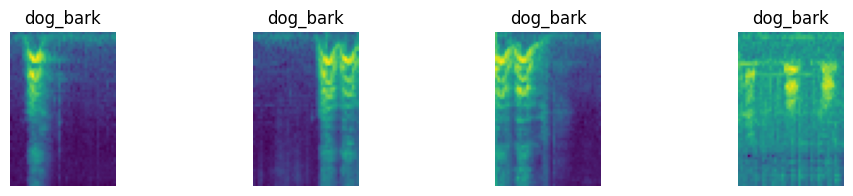

In [137]:
import matplotlib.pyplot as plt
from IPython.display import display


train0 = trains[0]

start = 0
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
for i in range(0, ncols):
    train_item = train0[start + i]
    audio_filename = train_item['audio']['path']
    updated_item = transform_item(train_item)

    print(f"Filename {i}: {audio_filename}")
    label = train_item['class']
    print(f"Label {i}: {label}")
    # Inline audio player
    # display(Audio(audio_filename, rate=sr))

    spectrogram = updated_item['tensor']
    ax = axes[i]
    ax.axis('on')
    ax.set_title(label)
    ax.axis("off")
    ax.imshow(spectrogram.log2().detach().numpy())
plt.show()

# Sample from the model

In [167]:
tr_loader, val_loader = data_loaders[0]
Xb, Yb = next(iter(val_loader))

logits = model.forward(Xb)
logits_classes = torch.argmax(logits, dim=1)

for i in range(0, 25):
    print(f"Label: {idx_to_class[Yb[i].item()]}")    
    print(f"Predicted: {idx_to_class[logits_classes[i].item()]}")    
    print()


Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: drilling
Predicted: drilling

Label: children_playing
Predicted: children_playing

Label: children_playing
Predicted: street_music

Label: children_playing
Predicted: street_music

Label: children_playing
Predicted: street_music

Label: children_playing
Predicted: street_music

Label: children_playing
Predicted: children_playing

Label: children_playing
Predicted: street_music

Label: children_playing
Predicted: children_playing

Label: air_conditioner
Predicted: car_horn

Label: air_conditioner
Predicted: car_horn

Label: air_conditioner
Predicted: gun_shot

Label: air_conditioner
Predicted: car_horn

Label: air_conditioner
Predicted: street_music

Label: children_playing
Predicted: children_playing

Label: children_playing